# Assignment 2: FIFA Regression Problem - kelvin.ahiakpor

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import streamlit as st
import matplotlib.pyplot as plt

from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from joblib import Parallel, delayed
from dill import dump
from pathlib import Path

### Setting job timeout for computation

In [2]:
os.environ['JOBLIB_START_METHOD'] = 'loky'
os.environ['JOBLIB_TIMEOUT'] = '300'

### Loading data

In [3]:
players = pd.read_csv('male_players (legacy).csv', low_memory=False)
players_22 = pd.read_csv('players_22.csv', low_memory=False)

### Understanding the data

##### Custom recipes for Data Loading and Inspection

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3) 

##### Peek at training data

In [5]:
print(f"Dimensions of data set is {players.shape} This is a large dataset.\n")
players.info()
players.head()

Dimensions of data set is (161583, 110) This is a large dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Columns: 110 entries, player_id to player_face_url
dtypes: float64(18), int64(45), object(47)
memory usage: 135.6+ MB


,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/150002,15,2,2014-09-18,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,1.005e+08,550000.0,27,1987-06-24,169,67,53.0,La Liga,1.0,241.0,FC Barcelona,CF,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,CF,10.0,Left,3,4,5,Medium/Low,Normal (170-),Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...","Finesse Shot, Speed Dribbler (AI), One Club Pl...",93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,NaN,89+3,89+3,89+3,92+3,90+3,90+3,90+3,92+3,92+3,92+3,92+3,90+3,79+3,79+3,79+3,90+3,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png
1,20801,/player/20801/c-ronaldo-dos-santos-aveiro/150002,15,2,2014-09-18,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,7.900e+07,375000.0,29,1985-02-05,185,80,53.0,La Liga,1.0,243.0,Real Madrid CF,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LW,7.0,Right,4,5,5,High/Low,Normal (185+),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,NaN,91+1,91+1,91+1,89+3,91+1,91+1,91+1,89+3,89+3,89+3,89+3,87+3,77+3,77+3,77+3,87+3,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png
2,9014,/player/9014/arjen-robben/150002,15,2,2014-09-18,A. Robben,Arjen Robben,"RM, LM, RW",90,90,5.450e+07,275000.0,30,1984-01-23,180,80,19.0,Bundesliga,1.0,21.0,FC Bayern München,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RS,11.0,Left,2,4,5,High/Low,Normal (170-185),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Diver, Injury Prone, Avoids Using Weaker Foot,...",93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,NaN,84+3,84+3,84+3,88+2,87+3,87+3,87+3,88+2,88+2,88+2,88+2,87+3,78+3,78+3,78+3,87+3,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png
3,41236,/player/41236/zlatan-ibrahimovic/150002,15,2,2014-09-18,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,5.250e+07,275000.0,32,1981-10-03,195,95,16.0,Ligue 1,1.0,73.0,Paris Saint-Germain,ST,10.0,NaN,2012-07-01,2016.0,46,Sweden,1363.0,ST,10.0,Right,4,4,5,Medium/Low,Normal (185+),Yes,NaN,"#Poacher, #Aerial Threat, #Distance Shooter, #...","Power Free-Kick, Leadership, Flair, Long Shot ...",76.0,91.0,81.0,86.0,34.0,86.0,76,91,76,84,92,8

##### Quick statistics
Extended Five-number Summary,
Histogram Plots,
Correlation Matrix,
Categorical Variable Selection &
Strongly Correlated Numeric Features

In [6]:
print("Extended Five-number Summary")
players.describe()

Extended Five-number Summary


,player_id,fifa_version,fifa_update,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,league_level,club_team_id,club_jersey_number,club_contract_valid_until_year,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,161583.000,161583.000,161583.0,161583.000,161583.000,1.595e+05,159822.000,161583.000,161583.00,161583.000,159810.000,158866.000,159810.000,159810.000,159810.000,161583.000,9316.000,9316.000,161583.000,161583.000,161583.000,1.036e+05,143614.000,143614.000,143614.000,143614.000,143614.000,143614.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,161583.000,128722.000,161583.000,161583.000,161583.000,161583.00,161583.000,161583.000,161583.000,161583.000,17969.000
mean,214484.722,19.126,2.0,65.699,70.744,2.327e+06,10855.410,25.123,181.24,75.235,210.409,1.380,44914.265,20.161,2020.352,55.570,30414.310,12.094,2.939,2.330,1.107,4.797e+06,68.023,52.231,56.938,62.082,51.133,64.814,49.659,45.618,52.251,58.362,43.035,55.221,47.305,43.059,52.602,58.207,64.707,64.879,63.379,61.577,63.943,56.719,64.943,63.091,65.152,47.153,55.702,46.583,49.996,53.067,48.668,57.817,45.758,47.670,45.699,16.53,16.275,16.140,16.289,16.637,39.149
std,34928.609,2.559,0.0,7.041,6.259,6.006e+06,21941.656,4.670,6.75,7.000,444.685,0.751,53413.303,16.870,2.662,47.892,48296.823,6.720,0.663,0.752,0.384,1.231e+07,11.096,13.922,10.485,10.301,16.640,9.737,18.002,19.228,17.128,14.686,17.432,18.593,18.076,17.229,15.226,16.567,14.721,14.472,14.692,9.170,14.025,15.522,11.900,15.821,12.613,19.010,17.220,20.382,19.172,14.269,15.652,12.330,20.454,21.336,20.935,17.67,16.834,16.476,16.999,17.980,10.504
min,2.000,15.000,2.0,40.000,40.000,1.000e+03,500.000,16.000,154.00,49.000,1.000,1.000,1.000,1.000,2014.000,1.000,974.000,1.000,1.000,1.000,1.000,9.000e+03,21.000,14.000,20.000,22.000,14.000,27.000,5.000,2.000,4.000,7.000,3.000,2.000,4.000,3.000,5.000,5.000,11.000,11.000,11.000,20.000,10.000,2.000,13.000,10.000,12.000,3.000,2.000,3.000,2.000,3.000,5.000,3.000,1.000,2.000,3.000,1.00,1.000,1.000,1.000,1.000,12.000
25%,199159.000,17.000,2.0,61.000,66.000,3.250e+05,2000.000,21.000,176.00,70.000,19.000,1.000,450.000,8.000,2018.000,21.000,1343.000,6.000,3.000,2.000,1.000,6.100e+05,62.000,42.000,50.000,56.000,36.000,58.000,38.000,30.000,44.000,53.000,30.000,48.000,34.000,31.000,43.000,54.000,57.000,57.000,55.000,55.000,56.000,47.000,58.000,56.000,58.000,32.000,44.000,26.000,38.000,44.000,39.000,50.000,26.000,27.000,25.000,8.00,8.000,8.000,8.000,8.000,31.000
50%,220621.000,19.000,2.0,66.000,70.000,7.250e+05,4000.000,25.000,181.00,75.000,56.000,1.000,1889.000,17.000,2021.000,45.000,1365.000,12.000,3.000,2.000,1.000,1.300e+06,69.000,54.000,58.000,63.000,56.000,66.000,54.000,49.000,55.000,62.000,44.000,61.000,48.000,42.000,56.000,63.000,67.000,67.000,65.000,62.000,66.000,59.000,66.000,66.000,66.000,51.000,58.000,52.000,55.000,55.000,50.000,59.000,50.000,54.000,52.000,11.00,11.000,11.000,11.000,11.000,41.000
75%,236958.000,21.000,2.0,70.000,75.000,1.800e+06

Histogram Plots


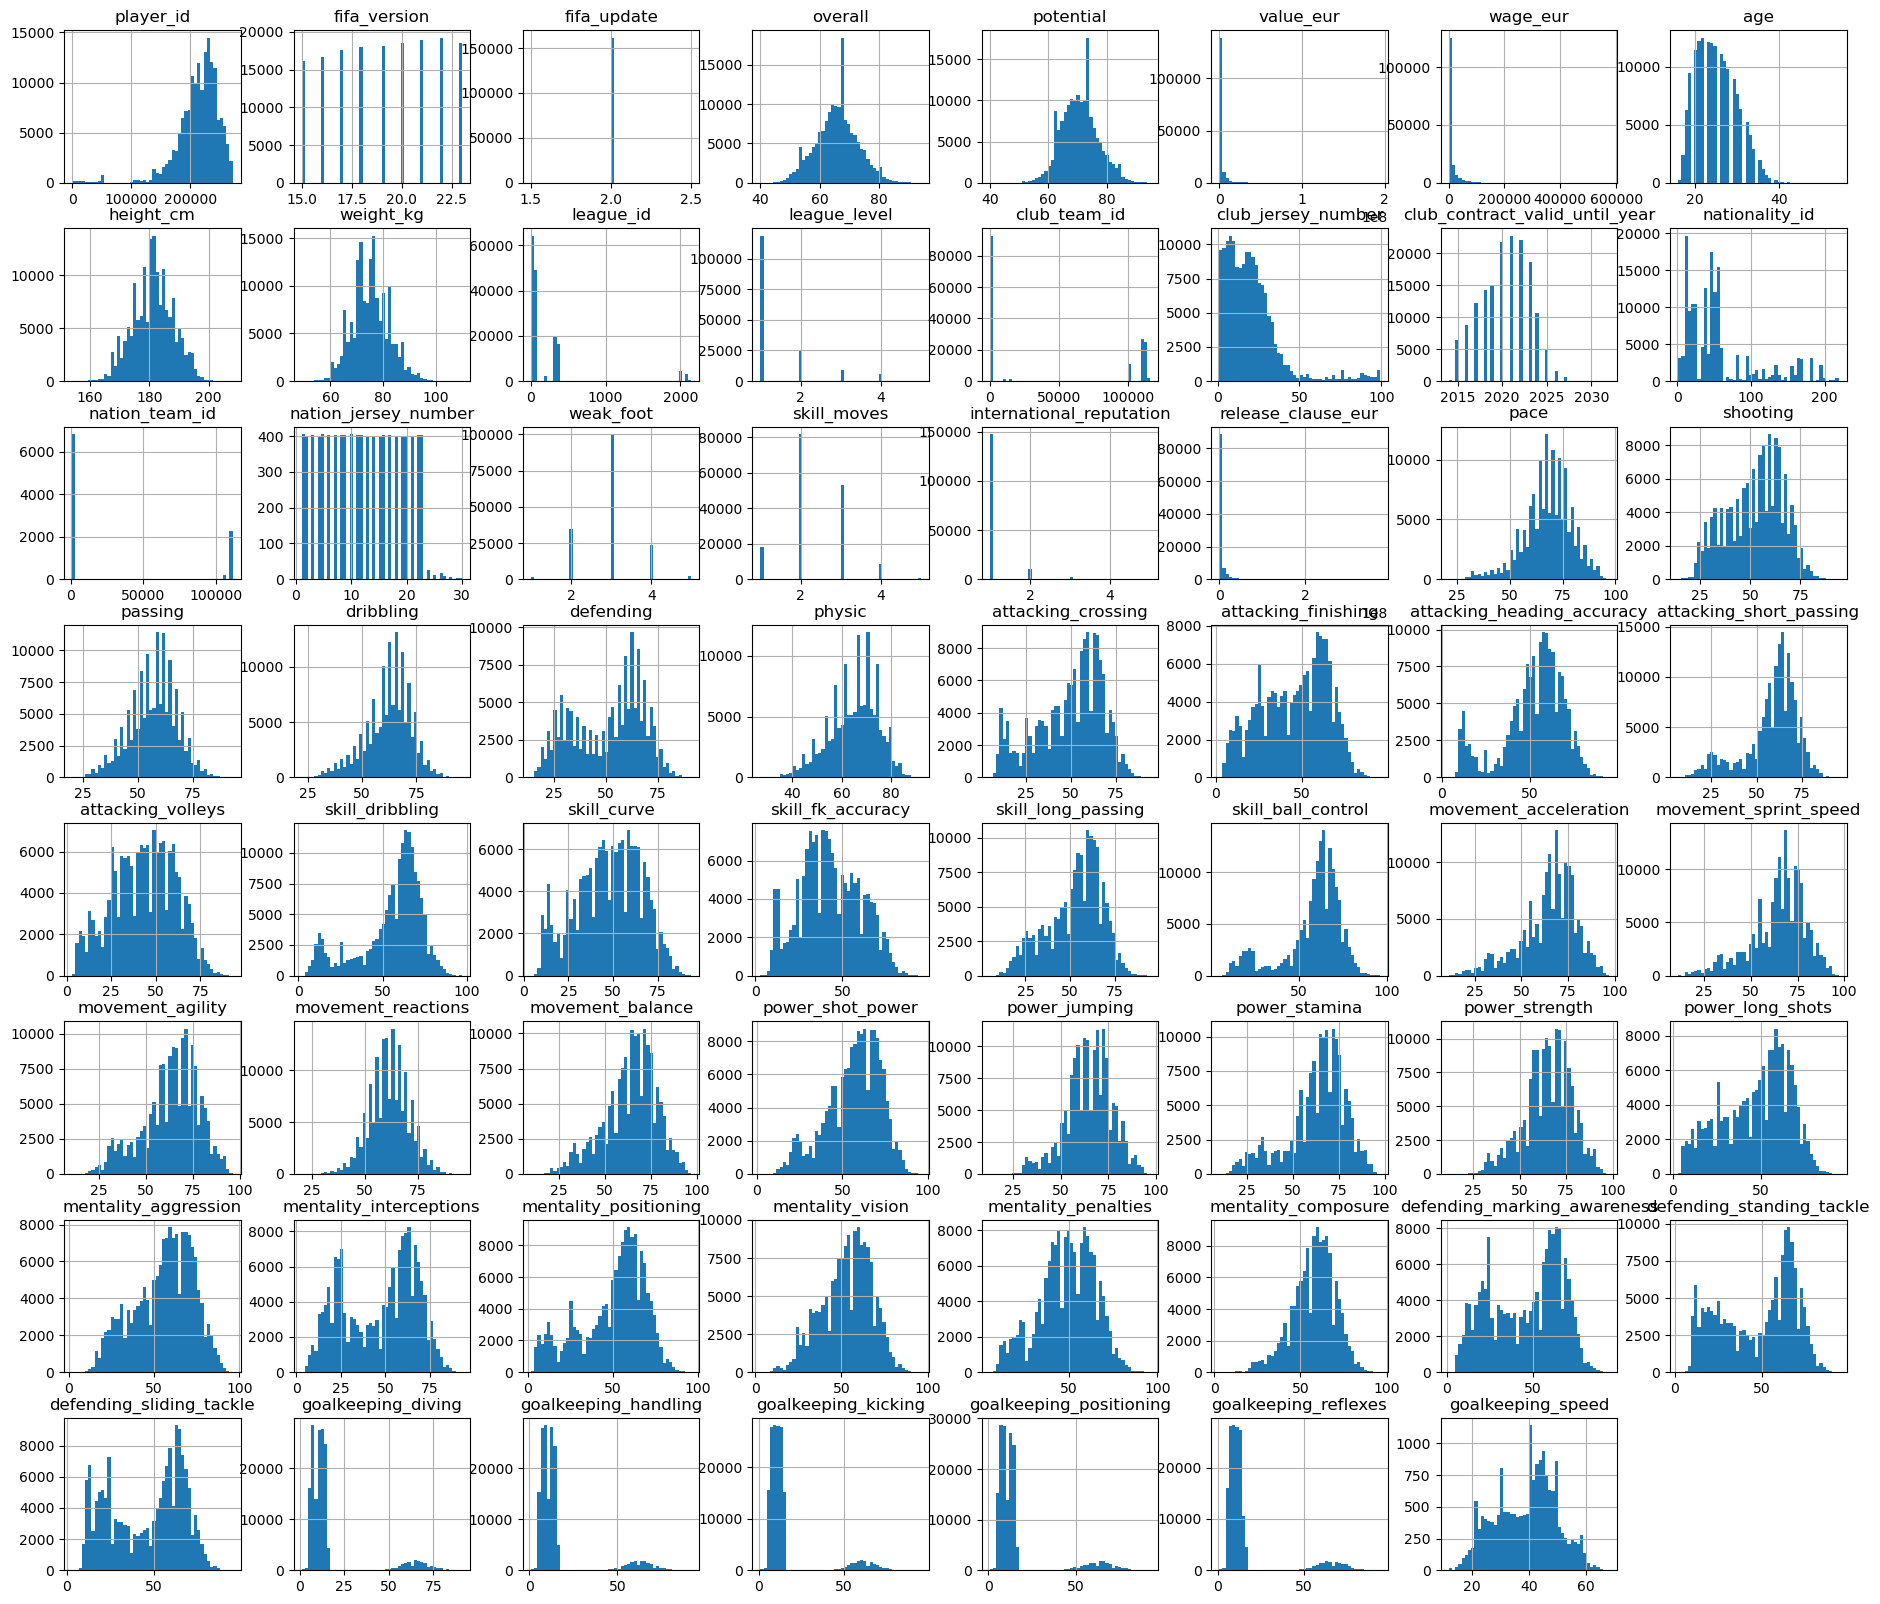

In [7]:
%matplotlib inline
players.hist(bins=50, figsize=(23,20))
print("Histogram Plots")
plt.show()

In [8]:
print("Correlation Matrix")
quant_players = players.select_dtypes(include=[np.int64, np.float64])
corrMat = quant_players.corr()
corrMat

Correlation Matrix


,player_id,fifa_version,fifa_update,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,league_level,club_team_id,club_jersey_number,club_contract_valid_until_year,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
player_id,1.000,4.339e-01,NaN,-0.369,0.037,-0.080,-0.252,-0.640,-0.075,-0.174,0.156,-3.430e-02,0.125,0.167,0.437,0.091,0.121,0.086,-0.085,-0.036,-0.333,-0.110,1.390e-01,-0.224,-0.303,-0.167,-0.175,-0.312,-0.133,-0.080,-0.121,-0.122,-0.161,-0.034,-1.570e-01,-0.197,-0.165,-0.098,0.101,0.096,-0.022,-0.378,0.039,-0.169,-0.161,-0.069,-0.238,-0.164,-0.212,-0.149,-0.084,-0.169,-0.150,-0.346,-0.092,-0.080,-0.065,-8.648e-02,-0.090,-0.086,-0.095,-8.705e-02,-0.317
fifa_version,0.434,1.000e+00,NaN,0.047,0.093,0.088,-0.086,0.032,0.018,-0.019,0.183,-4.816e-04,0.059,0.030,0.826,0.039,-0.065,0.013,0.008,0.043,-0.030,0.026,-1.834e-03,0.014,0.041,0.054,0.035,0.001,-0.006,0.011,-0.023,0.037,-0.029,0.024,6.188e-04,-0.031,0.030,0.015,-0.017,-0.025,0.006,0.007,0.002,0.054,-0.013,-0.012,-0.007,-0.025,-0.005,-0.003,0.012,0.066,-0.041,0.034,0.043,0.011,0.005,-1.540e-04,0.002,0.003,0.003,-8.939e-04,-0.247
fifa_update,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overall,-0.369,4.749e-02,NaN,1.000,0.695,0.567,0.611,0.458,0.044,0.140,-0.152,-2.217e-01,-0.178,-0.187,0.072,-0.094,-0.339,-0.086,0.217,0.331,0.485,0.579,1.872e-01,0.482,0.681,0.607,0.325,0.513,0.397,0.326,0.340,0.500,0.377,0.370,4.159e-01,0.387,0.484,0.457,0.195,0.209,0.264,0.846,0.099,0.480,0.276,0.360,0.351,0.409,0.398,0.314,0.350,0.493,0.334,0.683,0.274,0.251,0.220,-1.360e-02,-0.011,-0.016,-0.005,-1.178e-02,0.385
potential,0.037,9.266e-02,NaN,0.695,1.000,0.534,0.511,-0.202,0.007,-0.008,-0.196,-1.935e-01,-0.262,-0.004,0.157,-0.168,-0.319,-0.041,0.167,0.285,0.367,0.559,2.636e-01,0.318,0.456,0.488,0.159,0.185,0.264,0.246,0.209,0.383,0.256,0.324,2.929e-01,0.236,0.341,0.367,0.240,0.245,0.235,0.541,0.132,0.327,0.130,0.212,0.099,0.270,0.198,0.164,0.254,0.359,0.225,0.424,0.153,0.152,0.135,-4.483e-02,-0.044,-0.049,-0.043,-4.416e-02,0.191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
goalkeeping_handling,-0.090,2.465e-03,NaN,-0.011,-0.044,-0.016,-0.020,0.110,0.361,0.340,-0.007,-1.597e-02,-0.006,0.001,-0.006,-0.023,-0.017,-0.045,-0.227,-0.607,0.008,-0.022,-2.714e-03,0.025,0.033,0.018,0.015,0.037,-0.653,-0.574,-0.738,-0.719,-0.575,-0.743,-5.970e-01,-0.547,-0.589,-0.781,-0.591,-0.597,-0.524,-0.053,-0.499,-0.490,-0.181,-0.691,-0.099,-0.597,-0.573,-0.481,-0.666,-0.400,-0.613,-0.446,-0.513,-0.522,-0.502,9.695e-01,1.000,0.965,0.969,9.696e-01,0.294
goalkeeping_kicking,-0.086,2.967e-03,NaN,-0.016,-0.049,-0.017,-0.022,0.108,0.358,0.338,-0.006,-1.926e-02,-0.004,0.002,-0.006,-0.019,-0.016,-0.040,-0.223,-0.605,0.006,-0.023,1.823e-04,0.035,0.031,0.022,0.012,0.036,-0.652,-0.572,-0.735,-

In [9]:
print("Categorical Variable Selection")
cat_players = players.select_dtypes(include=[object])
cat_players = cat_players[["work_rate"]]

for column in cat_players.columns:
    print(cat_players[column].value_counts())
    print()
    
cat_players.head()

Categorical Variable Selection
work_rate
Medium/Medium    88772
High/Medium      27830
Medium/High      14562
High/High         7902
Medium/Low        7843
High/Low          6444
Low/Medium        4071
Low/High          3824
Low/Low            335
Name: count, dtype: int64



,work_rate
0,Medium/Low
1,High/Low
2,High/Low
3,Medium/Low
4,Medium/Medium


In [10]:
print("Most Correlated Numeric Features")
most_correlated = corrMat["overall"].abs()[corrMat["overall"].abs() > 0.50].sort_values(ascending=False)
most_correlated_cols = most_correlated.index.tolist()
most_correlated

Most Correlated Numeric Features


overall                1.000
movement_reactions     0.846
potential              0.695
mentality_composure    0.683
passing                0.681
wage_eur               0.611
dribbling              0.607
release_clause_eur     0.579
value_eur              0.567
physic                 0.513
Name: overall, dtype: float64

##### Descriptions of the most correlated numeric features from Kaggle
1. overall - player current overall attribute
2. movement_reactions - player reactions attribute
3. potential - player potential overall attribute
4. mentality_composure - player composure attribute
5. passing - player passing attribute
6. wage_eur - player weekly wage (in eur)
7. dribbling - player dribbling attribute
8. release_clause_eur - player release clause (in eur) - if applicable
9. value_eur - player value (in eur)
10. physic - player physic attribute

#### Some notes so far

1. Possible new features for feature engineering:   

    **Transformation Features** 
    - log_value_eur - the histogram plots show player value (`value_eur`) is heavily right skewed. Taking the logarithm helps us normalize.
    - log_wage_eur - the histogram plots show wages (`wage_eur`) is heavily right skewed. Taking the logarithm helps us normalize the distribution.
    - log_release_clause_eur - the histogram plots show release clause (`release_clause_eur`) is heavily right skewed. Try normalizing with log.

    **Interaction Features** 
    - passing_dribbling_interaction - helps us understand the combined effect of passing and dribbling on overall rating.

    **Ratio Features**
    - potential/value_eur ratio - a higher ratio may indicate that the player is undervalued relative to their potential (`potential`).
    - physic/movement_reactions ratio - a balanced ratio suggests a well-rounded player, while extremes may highlight specialized roles or weaknesses.
    - age vs potential ratio - with this ratio younger players are expected to have higher growth potential (`potential`). *
    - wage vs value ratio - this ratio shows how the value of a player's contributions (`wage_eur`) compare to their market value (`value_eur`). *
    - composure vs reactions ratio - better players make good decisions under pressure. A balanced ratio indicates a calm but swift player.
    - passing vs dribbling ratio - a higher ratio suggests a player is more proficient in distributing the ball relative to individual ball-handling skills.

    These ratios may (arguably*) influence overall player rating
    * age vs potential ratio - some players have an older peak age
    * wage vs value ratio - older players on higher wages may still have lower value 
    
    For transformation, we could use exponentiating if a left-skewed distributed was observed
    

2. Imputation:
   - Since not every player has a release clause, when imputing for N/As in release clause, simply use `value_eur`.
   - `value_eur` is the best estimation of the player's current or most recent valuation.
   - Use dataframe joining methods after removing duplicates. Concatenating will defeat the purpose of duplicate removal and add the duplicate rows back.

3. Evaluation:
   - Since the dataset is large (150,000+ rows) use at least 5-fold cross-validation.
   - Spot checking?


# Question 1
Demonstrate the data preparation & feature extraction process

### Data Cleaning

##### From the quick statistics above, we identified the most relevant numeric columns. Now we pick only those

In [11]:
df = players[most_correlated_cols]
df

,overall,movement_reactions,potential,mentality_composure,passing,wage_eur,dribbling,release_clause_eur,value_eur,physic
0,93,94,95,NaN,86.0,550000.0,96.0,NaN,1.005e+08,63.0
1,92,90,92,NaN,81.0,375000.0,91.0,NaN,7.900e+07,79.0
2,90,89,90,NaN,83.0,275000.0,92.0,NaN,5.450e+07,64.0
3,90,85,90,NaN,81.0,275000.0,86.0,NaN,5.250e+07,86.0
4,90,89,90,NaN,NaN,300000.0,NaN,NaN,6.350e+07,NaN
...,...,...,...,...,...,...,...,...,...,...
161578,46,39,61,40.0,40.0,700.0,47.0,239000.0,1.100e+05,44.0
161579,46,42,58,35.0,29.0,750.0,34.0,193000.0,1.100e+05,57.0
161580,46,50,58,35.0,43.0,500.0,46.0,193000.0,1.100e+05,53.0
161581,46,45,70,43.0,36.0,500.0,46.0,383000.0,1.500e+05,42.0


In [12]:
df[df.duplicated()]

,overall,movement_reactions,potential,mentality_composure,passing,wage_eur,dribbling,release_clause_eur,value_eur,physic
2904,70,72,70,NaN,NaN,20000.0,NaN,NaN,1.600e+06,NaN
3007,70,66,70,NaN,NaN,20000.0,NaN,NaN,1.500e+06,NaN
3058,70,73,70,NaN,NaN,15000.0,NaN,NaN,1.100e+06,NaN
3495,69,66,69,NaN,NaN,9000.0,NaN,NaN,1.000e+06,NaN
3517,69,66,69,NaN,NaN,9000.0,NaN,NaN,1.000e+06,NaN
...,...,...,...,...,...,...,...,...,...,...
161365,50,47,62,25.0,NaN,500.0,NaN,155000.0,1.000e+05,NaN
161379,50,33,53,32.0,NaN,1000.0,NaN,81000.0,5.000e+04,NaN
161469,49,43,60,21.0,NaN,500.0,NaN,158000.0,9.000e+04,NaN
161524,48,41,61,21.0,NaN,500.0,NaN,198000.0,1.000e+05,NaN


##### Duplicates arise because some rows have the same values in these the 10 columns even though the original dataset has no duplicates.

In [13]:
df = df.drop_duplicates()

##### Imputing missing values

In [14]:
df.loc[df['release_clause_eur'].isnull(), 'release_clause_eur'] = df['value_eur']
#uses boolean series as rows, release clause as column. 
#each null release clause will now have the value of it's respective player's value

imputer_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

with open("./imputer.pkl", 'wb') as f:
    pkl.dump(imputer_pipeline, f)
    
df = pd.DataFrame(imputer_pipeline.fit_transform(df), columns=df.columns)
df

,overall,movement_reactions,potential,mentality_composure,passing,wage_eur,dribbling,release_clause_eur,value_eur,physic
0,93.0,94.0,95.0,57.828,86.000,550000.0,96.000,1.005e+08,1.005e+08,63.000
1,92.0,90.0,92.0,57.828,81.000,375000.0,91.000,7.900e+07,7.900e+07,79.000
2,90.0,89.0,90.0,57.828,83.000,275000.0,92.000,5.450e+07,5.450e+07,64.000
3,90.0,85.0,90.0,57.828,81.000,275000.0,86.000,5.250e+07,5.250e+07,86.000
4,90.0,89.0,90.0,57.828,56.937,300000.0,62.082,6.350e+07,6.350e+07,64.817
...,...,...,...,...,...,...,...,...,...,...
161057,46.0,39.0,61.0,40.000,40.000,700.0,47.000,2.390e+05,1.100e+05,44.000
161058,46.0,42.0,58.0,35.000,29.000,750.0,34.000,1.930e+05,1.100e+05,57.000
161059,46.0,50.0,58.0,35.000,43.000,500.0,46.000,1.930e+05,1.100e+05,53.000
161060,46.0,45.0,70.0,43.000,36.000,500.0,46.000,3.830e+05,1.500e+05,42.000


### Data Pre-processing

##### Encoding categorical features

In [15]:
encoding_pipeline = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False),cat_players.columns)
])

cat_players_encoded = encoding_pipeline.fit_transform(cat_players)

df2 = pd.DataFrame(cat_players_encoded, columns=encoding_pipeline.get_feature_names_out())
df2

,onehot__work_rate_High/High,onehot__work_rate_High/Low,onehot__work_rate_High/Medium,onehot__work_rate_Low/High,onehot__work_rate_Low/Low,onehot__work_rate_Low/Medium,onehot__work_rate_Medium/High,onehot__work_rate_Medium/Low,onehot__work_rate_Medium/Medium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
161578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
161579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
161580,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
161581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##### Merging the numeric and categorical data
We remain cautious of the dataframe dimensions. 

Since we removed duplicates in numeric dataframe we must maintain that row count in the merged dataframe for training. 

We join on unique column player_id which we will retrieve from players dataframe.

In [16]:
df.head()

,overall,movement_reactions,potential,mentality_composure,passing,wage_eur,dribbling,release_clause_eur,value_eur,physic
0,93.0,94.0,95.0,57.828,86.000,550000.0,96.000,1.005e+08,1.005e+08,63.000
1,92.0,90.0,92.0,57.828,81.000,375000.0,91.000,7.900e+07,7.900e+07,79.000
2,90.0,89.0,90.0,57.828,83.000,275000.0,92.000,5.450e+07,5.450e+07,64.000
3,90.0,85.0,90.0,57.828,81.000,275000.0,86.000,5.250e+07,5.250e+07,86.000
4,90.0,89.0,90.0,57.828,56.937,300000.0,62.082,6.350e+07,6.350e+07,64.817


In [17]:
df2.head() 

,onehot__work_rate_High/High,onehot__work_rate_High/Low,onehot__work_rate_High/Medium,onehot__work_rate_Low/High,onehot__work_rate_Low/Low,onehot__work_rate_Low/Medium,onehot__work_rate_Medium/High,onehot__work_rate_Medium/Low,onehot__work_rate_Medium/Medium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We have to add the player_id to our dataframes first.
Below we retrieve unique player_id from players into numeric and cateogrical dataframes

In [18]:
df.loc[:, 'player_id'] = players.loc[df.index, 'player_id'].values
df2.loc[:, 'player_id'] = players.loc[df2.index, 'player_id'].values
#The code below checks if the df has the correct ids from players even though we removed the duplicates initially
#didn't want a case where the id between the cleaned df mismatch the ids in the players
#The duplicates indices were retrieved from running this code: df[df.duplicated()]. 
#Some duplicate indicies to test [2904,161365,3007]

# print(players.iloc[161365]['player_id'])
# print(df.iloc[161365]['player_id'])

# print(players.iloc[161365]['player_id'])
# print(df.iloc[161365]['player_id'])
#Successful!

Finally, we merge!
... and drop player_id.

In [19]:
playersNeeded = pd.merge(df, df2, on='player_id')
playersNeeded.drop(columns=['player_id'], inplace=True)
playersNeeded

,overall,movement_reactions,potential,mentality_composure,passing,wage_eur,dribbling,release_clause_eur,value_eur,physic,onehot__work_rate_High/High,onehot__work_rate_High/Low,onehot__work_rate_High/Medium,onehot__work_rate_Low/High,onehot__work_rate_Low/Low,onehot__work_rate_Low/Medium,onehot__work_rate_Medium/High,onehot__work_rate_Medium/Low,onehot__work_rate_Medium/Medium
0,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825687,47.0,41.0,61.0,42.000,44.0,2000.0,50.0,2.500e+05,1.100e+05,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
825688,47.0,40.0,59.0,41.000,41.0,1000.0,50.0,2.040e+05,1.100e+05,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
825689,46.0,46.0,54.0,36.000,45.0,500.0,48.0,1.750e+05,1.000e+05,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
825690,46.0,41.0,55.0,43.000,46.0,900.0,46.0,1.750e+05,1.000e+05,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Question 2
Create feature subsets that show maximum correlation with the dependent variable

### Feature Engineering

In [20]:
dfP = playersNeeded
#Transformed Features
dfP['log_wage_eur'] = np.log(dfP['wage_eur'])
dfP['log_value_eur'] = np.log(dfP['value_eur'])
dfP['log_release_clause_eur'] = np.log(dfP['release_clause_eur'])
#Interaction Features
dfP['passing_dribbling_interaction'] = dfP['passing'] * dfP['dribbling']
#Ratio Features
dfP['potential_value_ratio'] = dfP['potential'] / dfP['value_eur']
dfP['physic_movement_reactions_ratio'] = dfP['physic'] / dfP['movement_reactions']
dfP['passing_dribbling_ratio'] = dfP['passing'] / dfP['dribbling']
dfP['wage_value_ratio'] = dfP['wage_eur'] / dfP['value_eur']
dfP['composure_reactions_ratio'] = dfP['mentality_composure'] / dfP['movement_reactions']
dfP.head()

,overall,movement_reactions,potential,mentality_composure,passing,wage_eur,dribbling,release_clause_eur,value_eur,physic,onehot__work_rate_High/High,onehot__work_rate_High/Low,onehot__work_rate_High/Medium,onehot__work_rate_Low/High,onehot__work_rate_Low/Low,onehot__work_rate_Low/Medium,onehot__work_rate_Medium/High,onehot__work_rate_Medium/Low,onehot__work_rate_Medium/Medium,log_wage_eur,log_value_eur,log_release_clause_eur,passing_dribbling_interaction,potential_value_ratio,physic_movement_reactions_ratio,passing_dribbling_ratio,wage_value_ratio,composure_reactions_ratio
0,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.218,18.426,18.426,8256.0,9.453e-07,0.67,0.896,0.005,0.615
1,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.218,18.426,18.426,8256.0,9.453e-07,0.67,0.896,0.005,0.615
2,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.218,18.426,18.426,8256.0,9.453e-07,0.67,0.896,0.005,0.615
3,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.218,18.426,18.426,8256.0,9.453e-07,0.67,0.896,0.005,0.615
4,93.0,94.0,95.0,57.828,86.0,550000.0,96.0,1.005e+08,1.005e+08,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.218,18.426,18.426,8256.0,9.453e-07,0.67,0.896,0.005,0.615


In [21]:
print("Most Correlated Features")
corrMat = dfP.corr()
most_correlated = corrMat["overall"].abs()[corrMat["overall"].abs() > 0.60].sort_values(ascending=False)
most_correlated_cols = most_correlated.index.tolist()
most_correlated

Most Correlated Features


overall                          1.000
log_value_eur                    0.911
log_release_clause_eur           0.878
movement_reactions               0.840
log_wage_eur                     0.775
potential                        0.705
wage_eur                         0.629
passing_dribbling_interaction    0.627
value_eur                        0.620
passing                          0.614
Name: overall, dtype: float64

The transformed features in our feature engineering came out with higher correlations as compared to the ratio features. 

The passing_dribbling_interaction also proved useful. 

Now we will move on, selecting only these 9 features and 1 label to train our model.

In [22]:
dfP = dfP[most_correlated_cols]
dfP

,overall,log_value_eur,log_release_clause_eur,movement_reactions,log_wage_eur,potential,wage_eur,passing_dribbling_interaction,value_eur,passing
0,93.0,18.426,18.426,94.0,13.218,95.0,550000.0,8256.0,1.005e+08,86.0
1,93.0,18.426,18.426,94.0,13.218,95.0,550000.0,8256.0,1.005e+08,86.0
2,93.0,18.426,18.426,94.0,13.218,95.0,550000.0,8256.0,1.005e+08,86.0
3,93.0,18.426,18.426,94.0,13.218,95.0,550000.0,8256.0,1.005e+08,86.0
4,93.0,18.426,18.426,94.0,13.218,95.0,550000.0,8256.0,1.005e+08,86.0
...,...,...,...,...,...,...,...,...,...,...
825687,47.0,11.608,12.429,41.0,7.601,61.0,2000.0,2200.0,1.100e+05,44.0
825688,47.0,11.608,12.226,40.0,6.908,59.0,1000.0,2050.0,1.100e+05,41.0
825689,46.0,11.513,12.073,46.0,6.215,54.0,500.0,2160.0,1.000e+05,45.0
825690,46.0,11.513,12.073,41.0,6.802,55.0,900.0,2116.0,1.000e+05,46.0


### Feature Scaling

In [23]:
X = dfP.drop('overall',axis=1)
y = dfP['overall']

pipeline = Pipeline([
    ('scaler', StandardScaler())
])

X_scaled = pipeline.fit_transform(X)
X_scaled

with open("./scaler.pkl", 'wb') as f:
    pkl.dump(pipeline, f)
    
X = pd.DataFrame(X_scaled, columns=X.columns)
X

,log_value_eur,log_release_clause_eur,movement_reactions,log_wage_eur,potential,wage_eur,passing_dribbling_interaction,value_eur,passing
0,3.397,2.918,3.510,3.547,3.807,25.306,4.098,18.746,2.843
1,3.397,2.918,3.510,3.547,3.807,25.306,4.098,18.746,2.843
2,3.397,2.918,3.510,3.547,3.807,25.306,4.098,18.746,2.843
3,3.397,2.918,3.510,3.547,3.807,25.306,4.098,18.746,2.843
4,3.397,2.918,3.510,3.547,3.807,25.306,4.098,18.746,2.843
...,...,...,...,...,...,...,...,...,...
825687,-1.722,-1.272,-2.572,-0.779,-1.807,-0.504,-1.448,-0.493,-1.484
825688,-1.722,-1.414,-2.686,-1.313,-2.138,-0.551,-1.585,-0.493,-1.793
825689,-1.794,-1.522,-1.998,-1.847,-2.963,-0.574,-1.485,-0.495,-1.381
825690,-1.794,-1.522,-2.572,-1.394,-2.798,-0.556,-1.525,-0.495,-1.278


# Question 3
Create and train a suitable machine learning model with cross-validation that can predict a player's rating

We will fit and train 3 models with cross validation and select the best one. 

Metrics are models are defined in dictionaries with their inbuilt scorer names

In our cross validation, we will shuffle the dataset since it is currently ordered from best to worst player

In [24]:
models = {
    'RandomForest': RandomForestRegressor(random_state=8),
    'XGBoost': XGBRegressor(random_state=8),
    'GradientBoost': GradientBoostingRegressor(random_state=8)
}

In [25]:
predictions = {}

### Model Training

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=8, test_size=0.2)

In [27]:
kfold = KFold(n_splits=3, random_state=8, shuffle=True)
for name, model in models.items():
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2',n_jobs=-1)
    #dump(model, open("./models/Fifa"+model.__class__.__name__ + ".pkl", mode="wb"))
    #split("./models/Fifa"+model.__class__.__name__ + ".pkl", "./models/", int(5E7))
    predictions[name] = model.predict(X_test)
    print(f"\n{name} Cross-Validation Scores:")
    print(scores)
    print(f"R2 Avg (sd): {scores.mean() * 100.0:.3f}% ({scores.std() * 100.0:.3f}%)")


RandomForest Cross-Validation Scores:
[0.99386095 0.99385784 0.99391345]
R2 Avg (sd): 99.388% (0.003%)

XGBoost Cross-Validation Scores:
[0.95523989 0.95521179 0.95508978]
R2 Avg (sd): 95.518% (0.007%)

GradientBoost Cross-Validation Scores:
[0.92993641 0.92872117 0.92927913]
R2 Avg (sd): 92.931% (0.050%)


# Question 4
Measure the model's performance and fine-tune it as a process of optimization

We will use RMSE to evaluate because it is an interpretable metric in same units as target variable (player rating)

In [28]:
metrics = {
    'RMSE': 'neg_root_mean_squared_error',
}

### Model Evaluation

In [32]:
for name, model in models.items():
    print(f"Evaluation for {name}:")
    rmse = np.sqrt(mean_squared_error(y_test,predictions[name]))
    print(f"  RMSE: {rmse:.2f}")

Evaluation for RandomForest:
  RMSE: 0.37
Evaluation for XGBoost:
  RMSE: 1.40
Evaluation for GradientBoost:
  RMSE: 1.75


Looking at both goodness of fit (R2) and RMSE we see that the Random Forest Regressor is the best model so we will fine tune and use it moving forward

### Fine-tuning
During fine tuning, re-testing and re-evaluation is done

Creating parameter dictionaries

In [68]:
param_grids = {
    'RandomForest': {
        'n_estimators': randint(50, 100),
        'max_features': randint(15, 20),
        'max_depth': [None, 10]
    }
}

Tuning Random Forest with Randomized Search

In [69]:
model = models['RandomForest']
param_grid = param_grids['RandomForest']
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, 
                             scoring='neg_root_mean_squared_error', cv=kfold, random_state=8, n_jobs=-1)
rsearch.fit(X_train, y_train)
best_model = rsearch.best_estimator_
print(f"\n{name} Best Parameters: {rsearch.best_params_}")
print(f"Best RMSE: {-rsearch.best_score_:.2f}")


GradientBoost Best Parameters: {'max_depth': None, 'max_features': 15, 'n_estimators': 95}
Best RMSE: 0.51


### Exporting model

In [82]:
def split(src, dest, wsize):
    src = Path(src)
    dest = Path(dest)
    dest.mkdir(exist_ok=True)

    partNum = 0
    with open(src, "rb") as f:
        while True:
            chunk = f.read(wsize)

            if not chunk:
                break

            partNum += 1
            filename = f"{src.stem}-{partNum}.pkl"
            with open(dest / filename, "wb") as p:
                p.write(chunk)

In [87]:
pkl.dump(best_model, open("./models/Fifa"+model.__class__.__name__ + ".pkl","wb"))
#dump(best_model, open("./models/Fifa"+model.__class__.__name__ + ".pkl", mode="wb"))
split("./models/Fifa"+model.__class__.__name__ + ".pkl", "./models/", int(5E7))

# Question 5
Use the data from another season (players_22) which was not used during the training to test how good is the model

Select features

In [45]:
features = ['overall', 'movement_reactions', 'potential', 'wage_eur', 'release_clause_eur', 'value_eur', 'passing', 'dribbling']

### Model Testing

Create function that automates the pipeline
- Impute
- Feature Engineer
- Scale
- Fit
- Predict
- Evaluate

In [84]:
def reconstruct_model_file(src_dir, model_name):
    src_dir = Path(src_dir)
    model_parts = sorted(src_dir.glob(f"{model_name}-*.pkl"))
    model_path = src_dir / f"{model_name}.pkl"

    with open(model_path, "wb") as f_out:
        for part_file in model_parts:
            with open(part_file, "rb") as f_in:
                f_out.write(f_in.read())

In [85]:
def preprocess_and_model(players_data):
    # select features
    players_22 = players_data[features].copy()  # Ensure original data is not modified

    # identify columns with NaN values
    nan_columns = players_22.columns[players_22.isna().any()].tolist()

    # impute NaN values with mean
    imputation_dict = {col: players_22[col].mean() for col in nan_columns}
    players_22.fillna(imputation_dict, inplace=True)

    # feature engineering
    players_22['log_wage_eur'] = np.log(players_22['wage_eur'])
    players_22['log_value_eur'] = np.log(players_22['value_eur'])
    players_22['log_release_clause_eur'] = np.log(players_22['release_clause_eur'])
    players_22['passing_dribbling_interaction'] = players_22['passing'] * players_22['dribbling']

    selected_features = ['overall','log_value_eur', 'log_release_clause_eur', 'movement_reactions', 'log_wage_eur', 'potential', 'wage_eur', 'passing_dribbling_interaction', 'value_eur', 'passing']
    players_22 = players_22[selected_features]
    
    # separate features and label
    X = players_22.drop('overall', axis=1)
    y = players_22['overall']

    # scale the features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # impute any remaining NaNs after feature engineering
    imputer = SimpleImputer(strategy='mean')
    X_final = imputer.fit_transform(X_scaled)
    
#     model_dir = "./models/"
#     model_name = "FifaRandomForestRegressor"
#     reconstruct_model_file(model_dir, model_name)
    
    # load and predict with the trained model
    with open("/Users/kelvin/Library/CloudStorage/OneDrive-AshesiUniversity/ASHESI/2ND YEAR/SEM 2/AI/assignments/assignment 2/models/FifaRandomForestRegressor.pkl", "rb") as model_file:
        model = pkl.load(model_file)

    predictions = model.predict(X_final)

    # evaluate
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2_value = r2_score(y, predictions)

    print("Evaluation scores of RandomForestRegressor on players dataset")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2_value*100:.2f}%")

Call the function

In [86]:
preprocess_and_model(players_22)

Evaluation scores of RandomForestRegressor on players dataset
RMSE: 3.13
R2: 79.29%


# Question 6
Deploy the model on a simple web page using either (Heroku, Streamlite, or Flask) and upload a video that shows how the model performs on the web page/site.

### Webpage Creation

The code below creates the webpage. It has been moved to a .py file to be run on a separate streamlit host

In [ ]:
# import streamlit as st
# import pandas as pd
# import numpy as np
# import pickle as pkl
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer

# # Load the trained model
# with open("/Users/kelvin/Library/CloudStorage/OneDrive-AshesiUniversity/ASHESI/2ND YEAR/SEM 2/AI/assignments/assignment 2/models/FifaRandomForestRegressor.pkl", "rb") as model_file:
#     model = pkl.load(model_file)

# # # Load the imputer
# # with open("./imputer.pkl", "rb") as imputer_file:
# #     imputer = pkl.load(imputer_file)

# # Load the scaler
# with open("/Users/kelvin/Library/CloudStorage/OneDrive-AshesiUniversity/ASHESI/2ND YEAR/SEM 2/AI/assignments/assignment 2/scaler.pkl", "rb") as scaler_file:
#     scaler = pkl.load(scaler_file)

# # Function to preprocess input data and predict using the trained model
# def predict_overall(player_data):
#     # Convert input data into a DataFrame
#     player_features = pd.DataFrame(player_data, index=[0])

#     # Handle the case where release_clause_eur is zero by setting it to value_eur
#     player_features.loc[player_features['release_clause_eur'] == 0, 'release_clause_eur'] = player_features['value_eur']

#     # Apply logarithm transformations
#     player_features['log_wage_eur'] = np.log(player_features['wage_eur'] + 1)
#     player_features['log_value_eur'] = np.log(player_features['value_eur'] + 1)
#     player_features['log_release_clause_eur'] = np.log(player_features['release_clause_eur'] + 1)
#     player_features['passing_dribbling_interaction'] = player_features['passing'] * player_features['dribbling']

#     selected_features = ['log_value_eur', 'log_release_clause_eur', 'movement_reactions', 'log_wage_eur', 'potential', 'wage_eur', 'passing_dribbling_interaction', 'value_eur', 'passing']
#     player_features = player_features[selected_features]

# #     # Impute missing values using the loaded imputer
# #     player_features_imputed = imputer.transform(player_features)

#     # Scale the input data using the loaded scaler
#     X_scaled = scaler.transform(player_features)

#     # Make predictions
#     predicted_rating = model.predict(X_scaled)

#     # For demonstration purpose, assuming a fixed margin of error (you can adjust this)
#     margin_of_error = 1.96 * 0.46  # Adjust based on your desired confidence level and RMSE

#     lower_bound = predicted_rating - margin_of_error
#     upper_bound = predicted_rating + margin_of_error

#     return predicted_rating[0], lower_bound[0], upper_bound[0]

# # Streamlit UI
# st.title('FIFA Player Rating Predictor')

# # Sidebar with input fields for features
# movement_reactions = st.number_input('Enter Movement Reactions', min_value=0, step=1)
# potential = st.number_input('Enter Potential', min_value=0, step=1)
# wage_eur = st.number_input('Enter Wage (EUR)', min_value=0, step=1)
# release_clause_eur = st.number_input('Enter Release Clause (EUR)', min_value=0, step=1)
# value_eur = st.number_input('Enter Value (EUR)', min_value=0, step=1)
# passing = st.number_input('Enter Passing', min_value=0, step=1)
# dribbling = st.number_input('Enter Dribbling', min_value=0, step=1)

# # Prepare player data for prediction
# player_data = {
#     'movement_reactions': movement_reactions,
#     'potential': potential,
#     'wage_eur': wage_eur,
#     'release_clause_eur': release_clause_eur,
#     'value_eur': value_eur,
#     'passing': passing,
#     'dribbling': dribbling
# }

# # Predict button
# if st.button('Predict Player Rating'):
#     # Make prediction
#     predicted_rating, lower_bound, upper_bound = predict_overall(player_data)

#     # Display results
#     st.success(f'Predicted Overall Rating: {predicted_rating:.2f}')
#     st.info(f'Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]')

### Deployment

### Video Plan

The plan for the video is as follows
- Find new data that our model has never seen
- Select data from the top, middle and end (high-low rating)
- Select players without release clause
- Concatenate into dataframe for predictions
- Show predictions for a high, medium, low rated and no release clause player

#### Loading completely new data

In [ ]:
players_19 = pd.read_csv('players_19.csv', low_memory=False)

In [ ]:
features = ['short_name','overall', 'movement_reactions', 'potential', 'wage_eur', 'release_clause_eur', 'value_eur', 'passing', 'dribbling']
no_release_clause = players_19[pd.isna(players_19['release_clause_eur'])].iloc[0:5]
players_19 = players_19[features]
no_release_clause = no_release_clause[features]

In [ ]:
players_19['release_clause_eur'] = players_19['release_clause_eur'].apply(lambda x: '{:.0f}'.format(x))
players_19['value_eur'] = players_19['value_eur'].apply(lambda x: '{:.0f}'.format(x))
players_19['wage_eur'] = players_19['wage_eur'].apply(lambda x: '{:.0f}'.format(x))

In [ ]:
players_19 = pd.concat([
    players_19.iloc[0:5],
    players_19.iloc[9000:9005],
    players_19.iloc[18080:18085],
    no_release_clause
])

Dataframe for predictions

In [ ]:
players_19

# References

[1]Jim Frost. 2018. Interpreting Correlation Coefficients. Statistics By Jim. Retrieved June 16, 2024 from https://statisticsbyjim.com/basics/correlations/

[2]Alboukadel Kassambara. 2018. Transform Data to Normal Distribution in R: Easy Guide. Datanovia. Retrieved June 17, 2024 from https://www.datanovia.com/en/lessons/transform-data-to-normal-distribution-in-r/#google_vignette

[3]Stefano Leone. 2021. FIFA 22 complete player dataset. Kaggle.com. Retrieved June 22, 2024 from https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset?resource=download&select=players_19.csv

[4]Stefano Leone. 2024. FIFA 23 complete player dataset. www.kaggle.com. Retrieved June 22, 2024 from https://www.kaggle.com/datasets/stefanoleone992/fifa-23-complete-player-dataset

[5]Hrvoje Smolic. 2024. How Much Data Do You Need for Machine Learning. Graphic Note. Retrieved June 16, 2024 from https://graphite-note.com/how-much-data-is-needed-for-machine-learning/#:~:text=The%20rule%2Dof%2Dthumb%20rule

[6]StackExchange. 2014. regression - What is the reason the log transformation is used with right-skewed distributions? Cross Validated. Retrieved June 17, 2024 from https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution

[7]StackExchange. 2023. How many features is too many when using feature selection methods? Data Science Stack Exchange. Retrieved June 16, 2024 from https://datascience.stackexchange.com/questions/122640/how-many-features-is-too-many-when-using-feature-selection-methods